In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from cartopy import crs as ccrs

### Q: How do we plot AOD using contourf and pcolormesh?

There are nan values in the longitude field that are causing errors in both pcolormesh and contourf. Contourf is okay if the z values (e.g., AOD) have NaNs, but both have errors if there are nans in the coordinate data (the x,y arguments)

In [95]:
fname='data/JRR-AOD_v2r3_j01_s202304220518119_e202304220519346_c202304220600390.nc'
aod_file_id = xr.open_dataset(fname, engine='h5netcdf')

AOD_550 = aod_file_id['AOD550']
AOD_lat = aod_file_id['Latitude']
AOD_lon = aod_file_id['Longitude']

You can see the nan values in the last few rows of the Longitude field:

In [96]:
AOD_lon

<xarray.DataArray 'Longitude' (Rows: 768, Columns: 3200)>
[2457600 values with dtype=float32]
Coordinates:
    Latitude   (Rows, Columns) float32 ...
    Longitude  (Rows, Columns) float32 ...
Dimensions without coordinates: Rows, Columns
Attributes:
    long_name:    Longitude
    units:        degrees_east
    comments:     Pixel longitude in field Longitude (degree)
    valid_range:  [-180.  180.]

You can also see the missing values if you plot the data using ```imshow()```

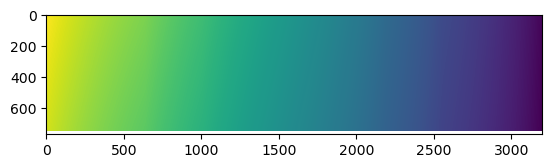

In [97]:
plt.figure()
plt.imshow(AOD_lon)
plt.show()

There are a couple of ways to delete these values. You could use index values to crop the last few rows from the matrix (e.g. ```AOD_lon[0:-10, 0:-10]```), but let's try to use a built in python function. We'll use xarray's ```.where()``` function. We'll have to pass in a mask.

In [98]:
mask = ~np.isnan(AOD_lon)
aod_file_id = aod_file_id.where(mask, drop=True)
aod_file_id

<xarray.Dataset>
Dimensions:             (Rows: 752, Columns: 3200, AbiAODnchn: 11, LndLUTnchn: 4)
Coordinates:
    Latitude            (Rows, Columns) float32 -32.75 -32.75 ... -32.89 -32.89
    Longitude           (Rows, Columns) float32 144.6 144.6 ... 110.8 110.8
Dimensions without coordinates: Rows, Columns, AbiAODnchn, LndLUTnchn
Data variables: (12/25)
    StartRow            (Rows, Columns) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    StartColumn         (Rows, Columns) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    QCExtn              (Rows, Columns) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QCTest              (Rows, Columns) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QCInput             (Rows, Columns) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QCPath              (Rows, Columns) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                  ...
    AOD550LndMdl        (Rows, Columns, LndLUTnchn) float32 nan nan ... nan nan
    ResLndMdl           (Rows, Columns, LndLUTnchn) float32 nan nan ... nan nan
    HighQualityPct      (Rows, Columns) float64 48.19 48.19 ... 48.19 48.19
    RetrievalPct        (Rows, Columns) float64 69.39 69.39 ... 69.39 69.39
    MeanAOD             (Rows, Columns) float64 0.04953 0.04953 ... 0.04953
    MeanAODHighQuality  (Rows, Columns) float64 0.04929 0.04929 ... 0.04929
Attributes: (12/39)
    Conventions:                              CF-1.5
    Metadata_Conventions:                     CF-1.5, Unidata Dataset Discove...
    standard_name_vocabulary:                 CF Standard Name Table (version...
    project:                                  JPSS Risk Reduction: Enterprise...
    institution:                              DOC/NOAA/NESDIS/NDE > S-NPP Dat...
    naming_authority:                         gov.noaa.nesdis.nde
    ...                                       ...
    geospatial_first_scanline_last_fov_lon:   111.19057
    geospatial_last_scanline_first_fov_lon:   142.35274
    geospatial_last_scanline_last_fov_lon:    110.78349
    geospatial_lat_units:                     degrees_north
    geospatial_lon_units:                     degrees_east
    geospatial_bounds:                        POLYGON((144.607 -32.7462,111.1...

We need to update our variables, becayse the file dimensions have changed.

In [99]:
AOD_550 = aod_file_id['AOD550']
AOD_lat = aod_file_id['Latitude']
AOD_lon = aod_file_id['Longitude']

Finally, we can plot!

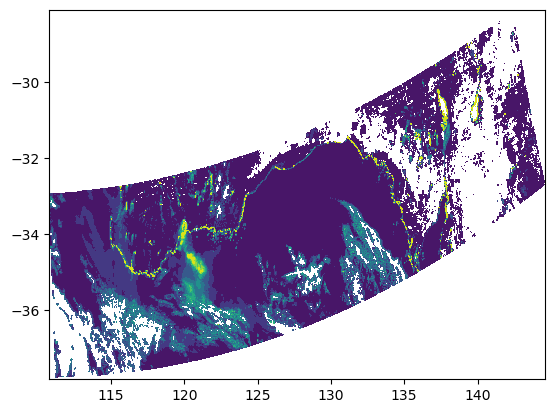

In [100]:
fig = plt.figure()
ax = plt.subplot(111)
ax.contourf(AOD_lon, AOD_lat, AOD_550, levels=np.arange(0,1,0.1))

plt.show()

C:\Users\rebekah\AppData\Local\Temp\ipykernel_52096\2142560245.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(AOD_lon, AOD_lat, AOD_550, vmin=0, vmax=1)


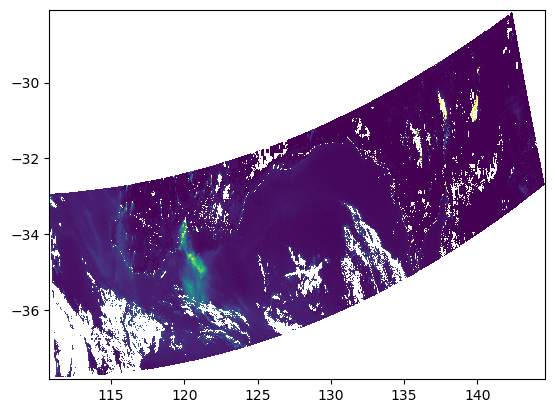

In [101]:
fig = plt.figure()
ax = plt.subplot(111)
ax.pcolormesh(AOD_lon, AOD_lat, AOD_550, vmin=0, vmax=1)

plt.show()

Unrelated, but the above code returns an warning (FYI, Warnings are okay! The code continues to run but take note of the message. On the other hand, errors are bad, the code cannot complete). This is because it treats the lat/lon coordinates as the center point, not cell edges... depending on the dataset, you can remove the last row/column using the -1 index. You may want to recalculate the lat/lon coordinates so that they're in between the current ones... but gridding discussions are out of scope of what I'm trying to show here :-)

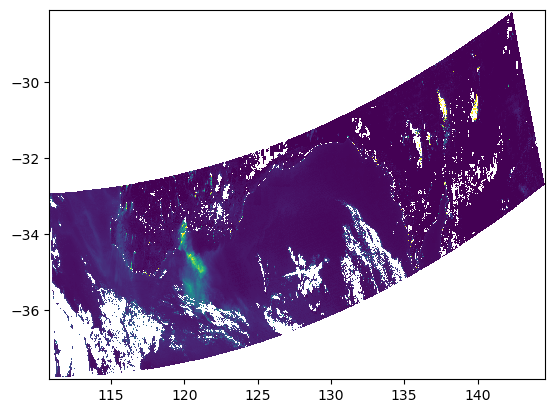

In [102]:
fig = plt.figure()
ax = plt.subplot(111)
ax.pcolormesh(AOD_lon, AOD_lat, AOD_550[:-1,:-1], vmin=0, vmax=1)

plt.show()

### Q: How do we decode times?

If the time variables don't look accurate after reading the dataset in, you can add the option ```decode_times=False``` so that the time variables are not converted.

In [103]:
filename = 'data/OR_ABI-L2-RSRF-M6_G16_s20231121800204_e20231121809512_c20231121859124.nc'
abi_L2_RSR = xr.open_dataset(filename, engine='h5netcdf', decode_times=False)
abi_L2_RSR

<xarray.Dataset>
Dimensions:                                 (lat: 652, lon: 652,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_wavelength_bounds: 2)
Coordinates:
    t                                       float64 ...
  * lat                                     (lat) float64 81.38 81.12 ... -81.38
  * lon                                     (lon) float64 -156.4 ... 6.375
    lat_image                               float32 ...
    lon_image                               float32 ...
    retrieval_local_zenith_angle            float32 ...
    quantitative_local_zenith_angle         float32 ...
    retrieval_solar_zenith_angle            float32 ...
    quantitative_solar_zenith_angle         float32 ...
    rsr_product_wavelength                  float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_wavelength_bounds
Data variables: (12/32)
    RSR                                     (lat, lon) float32 ...
    DQF                                     (lat, lon) float32 ...
    time_bounds                             (number_of_time_bounds) float64 ...
    goes_lat_lon_projection                 int32 ...
    lat_image_bounds                        (number_of_image_bounds) float32 ...
    lon_image_bounds                        (number_of_image_bounds) float32 ...
    ...                                      ...
    std_dev_rsr                             float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-04-22T18:00:20.4Z
    time_coverage_end:         2023-04-22T18:09:51.2Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        1e9f2b8a-9d88-4b0e-af12-3b9377fad411

If you print the values, you'll see that they are large numbers:

In [104]:
abi_L2_RSR.time_bounds.values

array([7.35458420e+08, 7.35458991e+08])

You can manually add the units if you know what they should be:

In [105]:
abi_L2_RSR.time_bounds.attrs = {'units': 'seconds since 2000-01-01 12:00:00'}

Replace the imported variable with the decoded one that has the units updated:

In [106]:
abi_L2_RSR = xr.decode_cf(abi_L2_RSR)

To check, print the values:

In [107]:
abi_L2_RSR.time_bounds.values

array(['2023-04-22T18:00:20.400055040', '2023-04-22T18:09:51.201217024'],
      dtype='datetime64[ns]')

### Q: How do we add latitude/longitude gridlines?

I didn't add any data to the map, but below shows an example of how to add the gridlines, as well as adding states, country borders, and the coastlines.

In [108]:
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

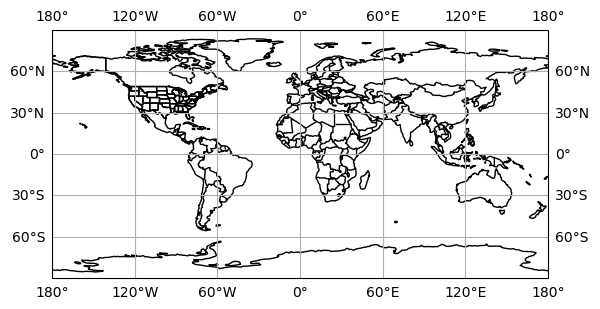

In [109]:
fig = plt.figure()

ax = plt.subplot(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

gl=ax.gridlines(draw_labels=True)
gl.xformatter=LongitudeFormatter()
gl.yformatter=LatitudeFormatter()

plt.show()